# Gradient Descent from Scratch
In this tutorial, we will be building gradient descent algorithm from the scratch
using `tensors` that we learned in the previous topic. It will test your knowledge
on `tensors` and its operations. First, we will import all
the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from fastai.vision.all import *

# MNIST Dataset
We will use the MNIST Sample dataset from the `Fastai` repository. This dataset contains
a stripped down version of the actual MNIST hand written digits. It contains the digits
$3$ and $7$ only. Our task will be build a `Logistic Regression` classifier to classify
the digits. First, we will create dataloaders for both training and validation data.

In [2]:
# Loads MNIST dataset from Fast.ai repository
# This trimmed dataset contains only 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample')

In [3]:
print(path.ls())

[Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/valid'), Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/labels.csv'), Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/train')]


In [4]:
print((path / 'train').ls())
print()
print((path / 'valid').ls())

[Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/train/7'), Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/train/3')]

[Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/valid/7'), Path('/Users/musabbirhasansammak/.fastai/data/mnist_sample/valid/3')]


### Training Set

In [5]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255

In [6]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

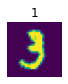

In [7]:
dset = list(zip(train_x, train_y))

x, y = dset[0]
show_titled_image((x.view(28, 28), str(y.item())))

### Validation Set

In [8]:
valid_stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_stacked_threes = valid_stacked_threes.float() / 255

valid_stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]) 
valid_stacked_sevens = valid_stacked_sevens.float() / 255

In [9]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_stacked_threes) + [0]*len(valid_stacked_sevens)).unsqueeze(1)

valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

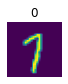

In [10]:
valid_dset = list(zip(valid_x, valid_y))

x, y = valid_dset[-1]
show_titled_image((x.view(28, 28), str(y.item())))

# Model
We will use a 2 layer neural network where the first hidden layer has 16 neurons and
the second hidden layer has 8 neurons. Our images are of size $28\times28$. 
Therefore we will need a total number of $784\times16$ weights for our first hidden
layer, in addition to $16$ bias parameters. In the second hidden layer, we will need
$16\times8$ weights and $8$ bias parameters. Finally, in the output layer, we will
need $8\times1$ weights and $1$ parameters.

### Initialize Parameters

In [49]:
def init_params(size, std=0.1):
    return (torch.randn(size) * std).requires_grad_()

In [50]:
w1 = init_params((28*28, 16))
b1 = init_params(16)
w2 = init_params((16, 8))
b2 = init_params(8)
w3 = init_params((8, 1))
b3 = init_params(1)

In [51]:
print(w1.data.shape)
print(b1.data.shape)
print(w2.data.shape)
print(b2.data.shape)
print(w3.data.shape)
print(b3.data.shape)

torch.Size([784, 16])
torch.Size([16])
torch.Size([16, 8])
torch.Size([8])
torch.Size([8, 1])
torch.Size([1])


### Activation Functions
We will define some useful activation functions that will be used in the model. We
will use `relu` in the hidden layers, and `sigmoid` for prediction.

In [52]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [53]:
def relu(x):
    return x.max(tensor(0.0))

### Model

In [54]:
def forward(x):
    x = x @ w1 + b1
    x = relu(x)
    x = x @ w2 + b2
    x = relu(x)
    x = x @ w3 + b3
    x = sigmoid(x)
    return x

### Loss Function
We will need a loss function for gradient descent. In this custom loss function,
we are simply calculating the distance from the prediction and the actual target.
Since the prediction will be ranged between $0$ and $1$ due the `sigmoid` function
in the output layer, we can safely avoid `MSE` loss function.

In [55]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

### Training

In [56]:
lr = 0.01
epochs = 25

In [57]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [58]:
for epoch in range(epochs):
    losses = []

    for xb, yb, in dl:
        preds = forward(xb)
        loss = mnist_loss(preds, yb)
        losses.append(loss.item())
        loss.backward()

        w1.data -= w1.grad * lr
        w2.data -= w2.grad * lr
        w3.data -= w3.grad * lr

        b1.data -= b1.grad * lr
        b2.data -= b2.grad * lr
        b3.data -= b3.grad * lr

        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()
        b3.grad.zero_()
    
    acc = []
    for vx, vy in valid_dl:
        v_preds = forward(vx)
        v_preds = torch.where(v_preds >= 0.5, 1, 0)
        acc.append(torch.sum(v_preds == vy).item() / vx.shape[0])

    print("Epoch {}: Loss {}, Validation Accuracy {}".format(epoch, sum(losses) / len(losses), 
            sum(acc) / len(acc)))

Epoch 0: Loss 0.495434045791626, Validation Accuracy 0.5068359375
Epoch 1: Loss 0.4939988778561962, Validation Accuracy 0.50830078125
Epoch 2: Loss 0.4920805437224252, Validation Accuracy 0.5078125
Epoch 3: Loss 0.48951365631453847, Validation Accuracy 0.513671875
Epoch 4: Loss 0.4860583659337491, Validation Accuracy 0.52197265625
Epoch 5: Loss 0.48140528676461203, Validation Accuracy 0.5380859375
Epoch 6: Loss 0.4750582308185344, Validation Accuracy 0.55712890625
Epoch 7: Loss 0.46626601352983593, Validation Accuracy 0.59521484375
Epoch 8: Loss 0.4538784793445042, Validation Accuracy 0.63232421875
Epoch 9: Loss 0.43614747207991933, Validation Accuracy 0.68310546875
Epoch 10: Loss 0.4110885359803025, Validation Accuracy 0.73388671875
Epoch 11: Loss 0.3772355388013684, Validation Accuracy 0.791015625
Epoch 12: Loss 0.3348839857748577, Validation Accuracy 0.8408004636686992
Epoch 13: Loss 0.2852718453018033, Validation Accuracy 0.8930465574186992
Epoch 14: Loss 0.23095537874163413, Valid